In [1]:
import re
import six
import math
import lmdb
import os
import numpy as np
import tensorflow as tf
import PIL
import cv2
import keras_ocr

from PIL import Image
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K

In [2]:
BATCH_SIZE = 128
HOME_DIR = os.getenv('HOME')+'/aiffel/ocr'

TRAIN_DATA_PATH = HOME_DIR+'/data/MJ/MJ_train'
VALID_DATA_PATH = HOME_DIR+'/data/MJ/MJ_valid'
TEST_DATA_PATH = HOME_DIR+'/data/MJ/MJ_test'

print(TRAIN_DATA_PATH)

/aiffel/aiffel/ocr/data/MJ/MJ_train


original image width:72, height:31
target_img_size:(74, 32)
display img shape:(74, 32, 3)
label:Lube


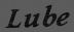

original image width:82, height:31
target_img_size:(84, 32)
display img shape:(84, 32, 3)
label:Spencerian


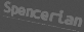

original image width:115, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:accommodatingly


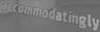

original image width:140, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:CARPENTER


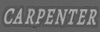

In [3]:
from IPython.display import display

# env에 데이터를 불러올게요
# lmdb에서 데이터를 불러올 때 env라는 변수명을 사용하는게 일반적이에요
env = lmdb.open(TRAIN_DATA_PATH, 
                max_readers=32, 
                readonly=True, 
                lock=False, 
                readahead=False, 
                meminit=False)

# 불러온 데이터를 txn(transaction)이라는 변수를 통해 엽니다
# 이제 txn변수를 통해 직접 데이터에 접근 할 수 있어요
with env.begin(write=False) as txn:
    for index in range(1, 5):
        # index를 이용해서 라벨 키와 이미지 키를 만들면
        # txn에서 라벨과 이미지를 읽어올 수 있어요
        label_key = 'label-%09d'.encode() % index
        label = txn.get(label_key).decode('utf-8')
        img_key = 'image-%09d'.encode() % index
        imgbuf = txn.get(img_key)
        buf = six.BytesIO()
        buf.write(imgbuf)
        buf.seek(0)

        # 이미지는 버퍼를 통해 읽어오기 때문에 
        # 버퍼에서 이미지로 변환하는 과정이 다시 필요해요
        try:
            img = Image.open(buf).convert('RGB')

        except IOError:
            img = Image.new('RGB', (100, 32))
            label = '-'

        # 원본 이미지 크기를 출력해 봅니다
        width, height = img.size
        print('original image width:{}, height:{}'.format(width, height))
        
        # 이미지 비율을 유지하면서 높이를 32로 바꿀거에요
        # 하지만 너비를 100보다는 작게하고 싶어요
        target_width = min(int(width*32/height), 100)
        target_img_size = (target_width,32)        
        print('target_img_size:{}'.format(target_img_size))        
        img = np.array(img.resize(target_img_size)).transpose(1,0,2)

        # 이제 높이가 32로 일정한 이미지와 라벨을 함께 출력할 수 있어요       
        print('display img shape:{}'.format(img.shape))
        print('label:{}'.format(label))
        display(Image.fromarray(img.transpose(1,0,2).astype(np.uint8)))

In [9]:
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS
print(f"The total number of characters is {len(TARGET_CHARACTERS)}")

The total number of characters is 36


In [4]:
class MJDatasetSequence(Sequence):
    # 객체를 초기화 할 때 lmdb를 열어 env에 준비해둡니다
    # 또, lmdb에 있는 데이터 수를 미리 파악해둡니다
    def __init__(self, 
                 dataset_path,
                 label_converter,
                 batch_size=1,
                 img_size=(100,32),
                 max_text_len=22,
                 is_train=False,
                 character='') :
        
        self.label_converter = label_converter
        self.batch_size = batch_size
        self.img_size = img_size
        self.max_text_len = max_text_len
        self.character = character
        self.is_train = is_train
        self.divide_length = 100

        # lmdb 데이터베이스를 읽기 전용 모드로 엽니다.
        self.env = lmdb.open(dataset_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
        with self.env.begin(write=False) as txn:
            # 데이터베이스에서 'num-samples' 키에 해당하는 값을 읽어와 데이터 수를 파악합니다.
            self.num_samples = int(txn.get('num-samples'.encode()))
            # index_list에 데이터 수에 해당하는 범위의 인덱스를 저장합니다.
            self.index_list = [index + 1 for index in range(self.num_samples)]
        

    def __len__(self):
        # 배치 크기와 데이터 수를 고려하여 데이터셋의 길이를 계산합니다.
        return math.ceil(self.num_samples/self.batch_size/self.divide_length)
    
    # index에 해당하는 image와 label을 읽어옵니다
    # 위에서 사용한 코드와 매우 유사합니다
    # label을 조금 더 다듬는 것이 약간 다릅니다
    def _get_img_label(self, index):
        with self.env.begin(write=False) as txn:
            # index에 해당하는 라벨 키와 이미지 키를 생성합니다.
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')
            img_key = 'image-%09d'.encode() % index
            imgbuf = txn.get(img_key)

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img = Image.open(buf).convert('RGB')

            except IOError:
                # 이미지가 없는 경우, 크기가 (100, 32)인 새로운 이미지를 생성하고 라벨을 '-'로 설정합니다.
                img = Image.new('RGB', self.img_size)
                label = '-'
            width, height = img.size
            
            # 이미지 비율을 유지하면서 너비를 self.img_size[0]보다 작게 조정합니다.
            target_width = min(int(width*self.img_size[1]/height), self.img_size[0])
            target_img_size = (target_width, self.img_size[1])
            img = np.array(img.resize(target_img_size)).transpose(1,0,2)
            
            # label을 약간 다듬습니다.
            label = label.upper()
            out_of_char = f'[^{self.character}]'
            label = re.sub(out_of_char, '', label)
            label = label[:self.max_text_len]

        return (img, label)
    
    # __getitem__은 약속되어있는 메서드입니다
    # 이 부분을 작성하면 slice할 수 있습니다
    # 자세히 알고 싶다면 아래 문서를 참고하세요
    # https://docs.python.org/3/reference/datamodel.html#object.__getitem__
    # 
    # 1. idx에 해당하는 index_list만큼 데이터를 불러
    # 2. image와 label을 불러오고 
    # 3. 사용하기 좋은 inputs과 outputs형태로 반환합니다
    def __getitem__(self, idx):
        # 1.
        # 배치 크기에 해당하는 index_list를 가져옵니다.
        batch_indicies = self.index_list[
            idx*self.batch_size:
            (idx+1)*self.batch_size
        ]
        input_images = np.zeros([self.batch_size, *self.img_size, 3])
        labels = np.zeros([self.batch_size, self.max_text_len], dtype='int64')

        input_length = np.ones([self.batch_size], dtype='int64') * self.max_text_len
        label_length = np.ones([self.batch_size], dtype='int64')

        # 2.
        for i, index in enumerate(batch_indicies):
            # index에 해당하는 이미지와 라벨을 읽어옵니다.
            img, label = self._get_img_label(index)
            encoded_label = self.label_converter.encode(label)
            # 인코딩 과정에서 '-'이 추가되면 max_text_len보다 길어질 수 있기 때문에 제외합니다.
            if len(encoded_label) > self.max_text_len:
                continue
            width = img.shape[0]
            input_images[i,:width,:,:] = img
            labels[i,0:len(encoded_label)] = encoded_label
            label_length[i] = len(encoded_label)
        
        # 3.
        inputs = {
            'input_image': input_images,
            'label': labels,
            'input_length': input_length,
            'label_length': label_length,
        }
        outputs = {'ctc': np.zeros([self.batch_size, 1])}

        return inputs, outputs


In [7]:
class LabelConverter(object):

    def __init__(self, character):
        self.character = "-" + character  # 입력된 character 앞에 "-"를 추가하여 저장합니다.
        self.label_map = dict()  # 빈 딕셔너리를 생성합니다.
        for i, char in enumerate(self.character):
            self.label_map[char] = i  # character의 각 문자에 대해 인덱스를 생성하여 label_map에 저장합니다.

    def encode(self, text):
        encoded_label = []  # 빈 리스트를 생성합니다.
        for i, char in enumerate(text):
            if i > 0 and char == text[i - 1]:
                encoded_label.append(0)  # 같은 문자 사이에 공백 문자의 label 0을 삽입합니다.
            encoded_label.append(self.label_map[char])  # 문자에 해당하는 인덱스를 encoded_label에 추가합니다.
        return np.array(encoded_label)  # encoded_label을 NumPy 배열로 반환합니다.

    def decode(self, encoded_label):
        target_characters = list(self.character)  # character 문자열을 리스트로 변환하여 target_characters에 저장합니다.
        decoded_label = ""  # 빈 문자열을 생성합니다.
        for encode in encoded_label:
            decoded_label += self.character[encode]  # 인덱스에 해당하는 문자를 decoded_label에 추가합니다.
        return decoded_label  # 디코딩된 label 문자열을 반환합니다.

In [10]:
label_converter = LabelConverter(TARGET_CHARACTERS)

encdoded_text = label_converter.encode('HELLO')
print("Encdoded_text: ", encdoded_text)
decoded_text = label_converter.decode(encdoded_text)
print("Decoded_text: ", decoded_text)

Encdoded_text:  [ 8  5 12  0 12 15]
Decoded_text:  HEL-LO


In [11]:
def ctc_lambda_func(args): # CTC loss를 계산하기 위한 Lambda 함수
    labels, y_pred, label_length, input_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [12]:
def build_crnn_model(input_shape=(100,32,3), characters=TARGET_CHARACTERS):
    num_chars = len(characters)+2  # 문자 개수에 2를 더한 값을 num_chars 변수에 저장합니다.
    image_input = layers.Input(shape=input_shape, dtype='float32', name='input_image')  # 입력 이미지에 대한 입력 레이어를 생성합니다.

    # CRNN 모델 구성
    conv = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(image_input)  # 64개의 3x3 필터를 가진 Convolutional 레이어를 생성합니다. 활성화 함수로는 ReLU를 사용합니다.
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)  # 2x2 크기의 MaxPooling 레이어를 추가합니다.
    conv = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)  # 128개의 3x3 필터를 가진 Convolutional 레이어를 생성합니다. 활성화 함수로는 ReLU를 사용합니다.
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)  # 2x2 크기의 MaxPooling 레이어를 추가합니다.
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)  # 256개의 3x3 필터를 가진 Convolutional 레이어를 생성합니다. 활성화 함수로는 ReLU를 사용합니다.
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)  # 256개의 3x3 필터를 가진 Convolutional 레이어를 생성합니다. 활성화 함수로는 ReLU를 사용합니다.
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)  # 1x2 크기의 MaxPooling 레이어를 추가합니다.
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)  # 512개의 3x3 필터를 가진 Convolutional 레이어를 생성합니다. 활성화 함수로는 ReLU를 사용합니다.
    conv = layers.BatchNormalization()(conv)  # Batch Normalization을 수행합니다.
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)  # 512개의 3x3 필터를 가진 Convolutional 레이어를 생성합니다. 활성화 함수로는 ReLU를 사용합니다.
    conv = layers.BatchNormalization()(conv)  # Batch Normalization을 수행합니다.
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)  # 1x2 크기의 MaxPooling 레이어를 추가합니다.
    feature = layers.Conv2D(512, (2, 2), activation='relu', kernel_initializer='he_normal')(conv)  # 512개의 2x2 필터를 가진 Convolutional 레이어를 생성합니다. 활성화 함수로는 ReLU를 사용합니다.
    sequnce = layers.Reshape(target_shape=(24, 512))(feature)  # Reshape 레이어를 사용하여 특성 맵의 차원을 변경합니다.
    sequnce = layers.Dense(64, activation='relu')(sequnce)  # 64개의 뉴런을 가진 Dense 레이어를 생성합니다. 활성화 함수로는 ReLU를 사용합니다.
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)  # 양방향 LSTM 레이어를 추가합니다.
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)  # 양방향 LSTM 레이어를 추가합니다.
    y_pred = layers.Dense(num_chars, activation='softmax', name='output')(sequnce)  # 문자 개수에 맞는 Dense 레이어를 생성합니다. 활성화 함수로는 softmax를 사용합니다.

    labels = layers.Input(shape=[22], dtype='int64', name='label')  # 레이블 입력 레이어를 생성합니다.
    input_length = layers.Input(shape=[1], dtype='int64', name='input_length')  # 입력 길이 입력 레이어를 생성합니다.
    label_length = layers.Input(shape=[1], dtype='int64', name='label_length')  # 레이블 길이 입력 레이어를 생성합니다.
    loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [labels, y_pred, label_length, input_length]
    )  # Lambda 레이어를 사용하여 CTC 손실 함수를 적용합니다.
    model_input = [image_input, labels, input_length, label_length]  # 모델의 입력을 정의합니다.
    model = Model(
        inputs=model_input,
        outputs=loss_out
    )  # 입력과 손실 출력으로 모델을 생성합니다.
    return model

In [13]:
# 데이터셋과 모델을 준비합니다
train_set = MJDatasetSequence(TRAIN_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS, is_train=True)  # 학습 데이터셋을 준비합니다.
val_set = MJDatasetSequence(VALID_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)  # 검증 데이터셋을 준비합니다.
model = build_crnn_model()  # CRNN 모델을 생성합니다.

# 모델을 컴파일 합니다
optimizer = tf.keras.optimizers.Adadelta(lr=0.1, clipnorm=5)  # Adadelta 옵티마이저를 생성합니다.
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)  # 모델을 컴파일합니다. 손실 함수로는 CTC 손실 함수를 사용하고, Adadelta 옵티마이저를 사용합니다.

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# ModelCheckpoint 설정
checkpoint_path = HOME_DIR + '/model_checkpoint.hdf5'
model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_weights_only=True, save_best_only=True)

# EarlyStopping 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

model.fit(train_set,
          steps_per_epoch=len(train_set),
          epochs=20,  # EarlyStopping을 사용하지 않을 경우 epoch을 20으로 설정
          validation_data=val_set,
          validation_steps=len(val_set),
          callbacks=[model_checkpoint, early_stopping]
)

Epoch 1/20
565/565 [==============================] - 161s 163ms/step - loss: 25.7946 - val_loss: 24.6346
Epoch 2/20
565/565 [==============================] - 84s 148ms/step - loss: 17.6548 - val_loss: 11.4138
Epoch 3/20
565/565 [==============================] - 84s 148ms/step - loss: 8.2229 - val_loss: 7.1999
Epoch 4/20
565/565 [==============================] - 83s 147ms/step - loss: 5.7215 - val_loss: 5.7299
Epoch 5/20
565/565 [==============================] - 83s 147ms/step - loss: 4.4952 - val_loss: 4.9962
Epoch 6/20
565/565 [==============================] - 83s 146ms/step - loss: 3.6865 - val_loss: 4.5862
Epoch 7/20
565/565 [==============================] - 83s 147ms/step - loss: 3.0595 - val_loss: 4.6405
Epoch 8/20
565/565 [==============================] - 84s 148ms/step - loss: 2.5501 - val_loss: 4.3115
Epoch 9/20
565/565 [==============================] - 84s 149ms/step - loss: 2.1116 - val_loss: 4.2589
Epoch 10/20
565/565 [==============================] - 84s 148ms/ste

In [15]:
# 데이터셋과 모델을 불러옵니다
test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()
model.load_weights(checkpoint_path)

# crnn 모델은 입력이 복잡한 구조이므로 그대로 사용할 수가 없습니다
# 그래서 crnn 모델의 입력중 'input_image' 부분만 사용한 모델을 새로 만들겁니다
# inference 전용 모델이에요 
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

Result: 	 SLINKING9999999999999999


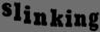

Result: 	 ALEPPO99999999999999999


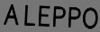

Result: 	 TWENDE999999999999999999


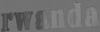

Result: 	 NATHANS99999999999999999


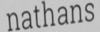

Result: 	 HALLO999999999999999999


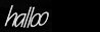

Result: 	 HURLS9999999999999999999


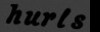

Result: 	 DOWNSIZE9999999999999999


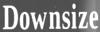

Result: 	 ROBOTIC99999999999999999


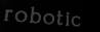

Result: 	 SLOPPY99999999999999999


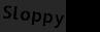

Result: 	 HERMITE99999999999999999


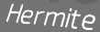

In [16]:
from IPython.display import display

# 모델이 inference한 결과를 글자로 바꿔주는 역할을 합니다
# 코드 하나하나를 이해하기는 조금 어려울 수 있습니다
def decode_predict_ctc(out, chars = TARGET_CHARACTERS):
    results = []
    indexes = K.get_value(
        K.ctc_decode(
            out, input_length=np.ones(out.shape[0]) * out.shape[1],
            greedy=False , beam_width=5, top_paths=1
        )[0][0]
    )[0]
    text = ""
    for index in indexes:
        text += chars[index]
    results.append(text)
    return results

# 모델과 데이터셋이 주어지면 inference를 수행합니다
# index개 만큼의 데이터를 읽어 모델로 inference를 수행하고
# 결과를 디코딩해 출력해줍니다
def check_inference(model, dataset, index = 5):
    for i in range(index):
        inputs, outputs = dataset[i]
        img = dataset[i][0]['input_image'][0:1,:,:,:]
        output = model.predict(img)
        result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
        print("Result: \t", result)
        display(Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))

check_inference(model_pred, test_set, index=10)

# Detector를 만들어 보자

In [17]:
from keras_ocr.detection import Detector

SAMPLE_IMG_PATH = HOME_DIR + '/data/sample.jpg'

detector = Detector()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5


In [32]:
import numpy as np
from PIL import Image, ImageDraw

def detect_text(img_path):
    # 이미지 로드
    img_pil = Image.open(img_path)
    img_draw = ImageDraw.Draw(img_pil)
    img_np = np.array(img_pil)

    # OCR 모델을 위한 이미지 전처리
    # 배치 크기를 위한 차원 확장 및 H,W,C에 맞게 차원 조정
    img_np = np.expand_dims(img_np, axis=0)
    img_np = img_np[..., ::-1] # keras-ocr은 이미지를 BGR 형식으로 사용하므로 RGB를 BGR로 변환

    # OCR 모델을 이미지에서 실행하고 결과를 가져옴
    # 배치에서 첫 번째 결과만 가져옴
    ocr_result = detector.detect(img_np)[0]

    cropped_imgs = []
    for text_result in ocr_result:
        # 시각화를 위해 이미지에 결과 그리기
        img_draw.polygon(text_result, outline='red')

        # 감지된 텍스트의 경계 상자를 가져옴
        x_min = text_result[:,0].min() - 5
        x_max = text_result[:,0].max() + 5
        y_min = text_result[:,1].min() - 5
        y_max = text_result[:,1].max() + 5
        word_box = [x_min, y_min, x_max, y_max]

        # 경계 상자를 기반으로 이미지를 자름
        cropped_imgs.append(img_pil.crop(word_box))

    return img_pil, cropped_imgs

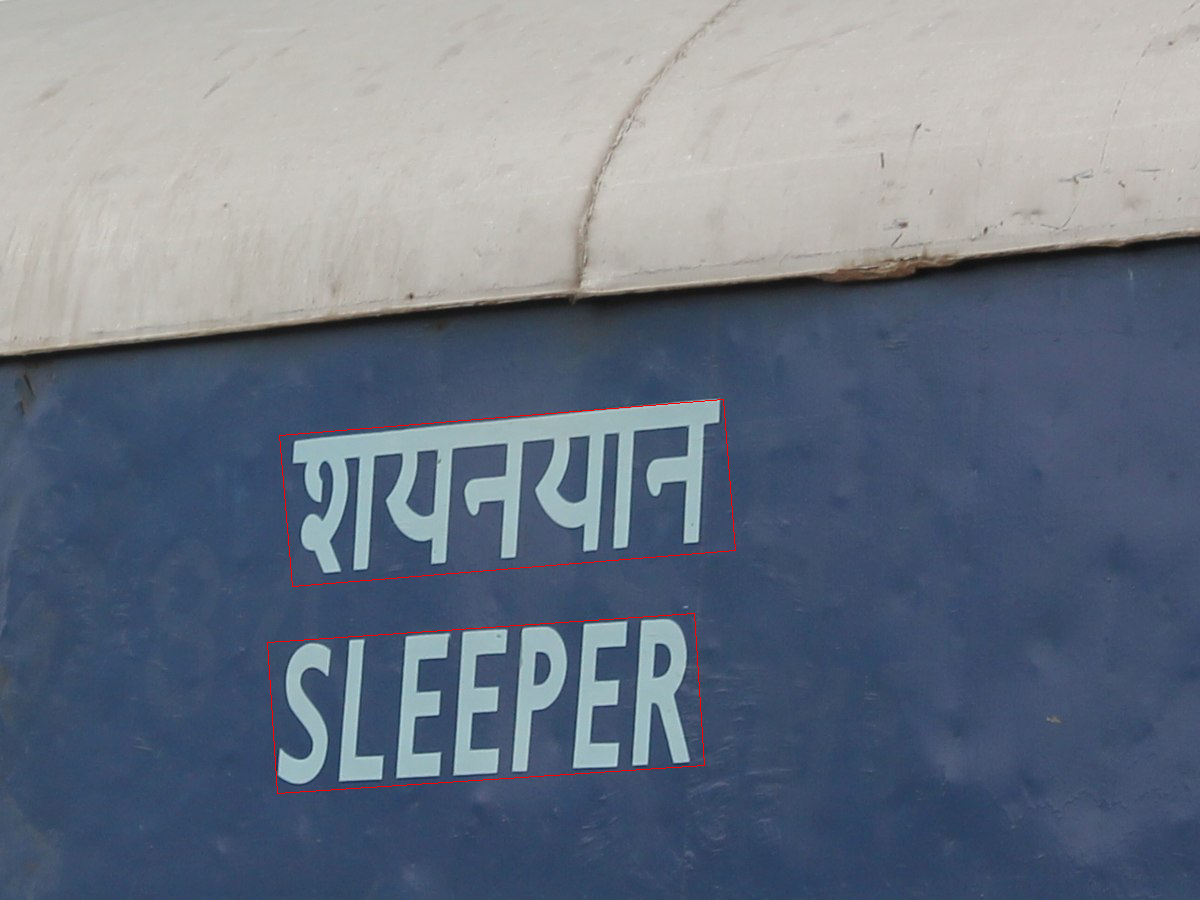

In [33]:
img_pil, cropped_img = detect_text(SAMPLE_IMG_PATH)
display(img_pil)

In [63]:
def recognize_img(pil_img, input_img_size=(100, 32)):
    pil_img = pil_img.resize(input_img_size)  # 이미지를 모델의 입력 크기에 맞게 재조정
    img = np.array(pil_img)  # 이미지 데이터를 numpy array로 변환

    # 이미지 데이터의 차원을 확장하여 모델의 입력으로 사용할 수 있게 함
    # (모델은 배치를 입력으로 받기 때문에, 개별 이미지도 하나의 배치로 취급해야 함)
    img = np.transpose(img, (1, 0, 2))  # 이미지 차원 전치

    # 이미지 데이터의 차원을 확장하여 모델의 입력으로 사용할 수 있게 함
    img = np.expand_dims(img, axis=0)

    # 모델을 통해 이미지 데이터에 대한 예측 수행
    output = model_pred.predict(img)
    result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-', '').replace("9", "")
    print(result)
    display(Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))


TUUIFL


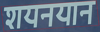

SLEEPER


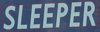

In [64]:
for _img in cropped_img:
    recognize_img(_img)

## 음 잘된다~!